In [1]:
from dataclasses import dataclass
from typing import Literal, Optional

import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers.models.gpt_neox.modeling_gpt_neox import GPTNeoXConfig, GPTNeoXModel, GPTNeoXPreTrainedModel
from transformers.utils import ModelOutput


class GPTNeoXRewardModelConfig(GPTNeoXConfig):
    model_type = "gpt_neox_reward_model"

    pooling: Literal["mean", "last"]

    def __init__(
        self,
        pooling: Literal["mean", "last"] = "last",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.pooling = pooling or "last"


@dataclass
class GPTNeoXRewardModelOutput(ModelOutput):
    """
    Reward model output.

    Args:
        logits (`torch.FloatTensor` of shape `(batch_size, 1)`):
            Reward score
    """

    logits: torch.FloatTensor = None
    hidden_states: Optional[torch.FloatTensor] = None


class GPTNeoXRewardModel(GPTNeoXPreTrainedModel):
    config_class = GPTNeoXRewardModelConfig

    def __init__(self, config):
        if type(config) == GPTNeoXConfig:
            # When a normal GPTNeoX was loaded it will be converted into a reward model.
            # The direct `type(config) == GPTNeoXConfig` comparison is used (instead of
            # `isinstance()`) since the configuration class of the reward model is also
            # derived form `GPTNeoXConfig`.
            config = GPTNeoXRewardModelConfig.from_dict(config.to_dict())
        super().__init__(config)

        self.gpt_neox = GPTNeoXModel(config)
        self.out_proj = nn.Linear(config.hidden_size, 1)
        self.pooling = config.pooling

    def forward(
        self,
        input_ids,
        attention_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        return_dict: Optional[bool] = True,
        output_hidden_states: Optional[bool] = None,
    ) -> GPTNeoXRewardModelOutput:
        outputs = self.gpt_neox(
            input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            return_dict=return_dict,
            output_hidden_states=output_hidden_states,
        )

        hidden_states = outputs[0]
        if self.pooling == "mean":
            if attention_mask is None:
                pooled = hidden_states.mean(dim=1)
            else:
                pooled = (hidden_states * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)
        elif self.pooling == "last":
            if attention_mask is None:
                pooled = hidden_states[:, -1]
            else:
                last_idx = attention_mask.cumsum(dim=1).argmax(dim=1)
                pooled = hidden_states.gather(1, last_idx.view(-1, 1, 1).expand(-1, 1, hidden_states.size(-1))).squeeze(
                    1
                )
        else:
            raise ValueError(f"Unknown pooling method: {self.pooling}")

        logits = self.out_proj(pooled)

        if not return_dict:
            return (logits,) + outputs[1:]

        return GPTNeoXRewardModelOutput(logits=logits, hidden_states=outputs.hidden_states if output_hidden_states else None)


AutoConfig.register("gpt_neox_reward_model", GPTNeoXRewardModelConfig)
AutoModelForSequenceClassification.register(GPTNeoXRewardModelConfig, GPTNeoXRewardModel)

/mnt/ssd-2/spar/alexm/miniconda3/envs/dlkb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "OpenAssistant/oasst-rm-2-pythia-6.9b-epoch-1"
device = "cuda:7"
rm = AutoModelForSequenceClassification.from_pretrained(model_name).to(device).half()
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


In [3]:
input_text = "<|prompter|>1+2=?<|endoftext|><|assistant|>1 + 2 equals 3.<|endoftext|>"
inputs = tokenizer(input_text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = rm(**inputs, return_dict=False)
hidden_states = outputs[1]
score = outputs[0][0].item()
print(score)

-1.15234375


In [4]:
len(outputs[1][0])

2

In [5]:
# note that the pythia-6.9B reward model was not just trained on OASST (69,000 assitant messages) 
# but also SHP (350k??), 0.1 of hh-rlhf (16k), half of hellaswag (20k), web_gpt (20k) and hf_summary_pairs

In [6]:
# load oasst dataset
import json
path = "oasst/2023-04-12_oasst_all.trees.jsonl"

with open(path, "r") as f:
    trees = [json.loads(line) for line in f.readlines()]

In [7]:
trees[0]

{'message_tree_id': '6ab24d72-0181-4594-a9cd-deaf170242fb',
 'tree_state': 'ready_for_export',
 'prompt': {'message_id': '6ab24d72-0181-4594-a9cd-deaf170242fb',
  'user_id': 'c3fe8c76-fc30-4fa7-b7f8-c492f5967d18',
  'created_date': '2023-02-05T14:23:50.983374+00:00',
  'text': 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.',
  'role': 'prompter',
  'lang': 'en',
  'review_count': 3,
  'review_result': True,
  'deleted': False,
  'synthetic': False,
  'emojis': {'+1': 10, '_skip_reply': 1, '_skip_ranking': 4},
  'replies': [{'message_id': 'c8e83833-ecbc-44fe-b6db-735228c25a1c',
    'parent_id': '6ab24d72-0181-4594-a9cd-deaf170242fb',
    'user_id': '2c96e467-66f0-4be7-9693-bda51356a424',
    'created_date': '2023-02-06T13:50:44.657083+00:00',
    'text': '"Monopsony" refers to a market structure where there is only one buyer for a particula

In [34]:
import random

no_ranks = 0
yes_ranks  = 0
results = {"tree_id": [], "prompt": [], "preferred": [], "rejected": [], "preferred_id": [], "rejected_id": []}
for tree in trees:
    if tree["tree_state"] != "ready_for_export":
        continue
    
    stack = [("", tree["prompt"])]  # prefix_text, node
    while stack:
        parent_prefix, current = stack.pop()
        if current.get("lang", None) != "en" or current.get("deleted", True) or not current.get("review_result", False):
            continue
        def get_prompt(node):
            if node["role"] == "prompter":
                return f"<|prompter|>{node['text']}<|endoftext|>"
            elif node["role"] == "assistant":
                return f"<|assistant|>{node['text']}<|endoftext|>"
            else:
                raise ValueError(f"Unknown role: {node['role']}")
        current_prompt = parent_prefix + get_prompt(current)
        stack.extend(list(zip([current_prompt] * len(current["replies"]), current["replies"])))

        if current["role"] == "prompter":
            if len(current["replies"]) >= 2:
                if not all("rank" in r for r in current["replies"]):
                    print("No rank found")
                    no_ranks += 1
                    continue
                else:
                    yes_ranks += 1
                if sorted([r["rank"] for r in current["replies"]]) != list(range(len(current["replies"]))):
                    print("\n\n\n\nMissing ranks\n\n\n\n")
                    continue
                # get random pair of data
                reply_pair = random.sample(current["replies"], 2)
                pref, rej = sorted(reply_pair, key=lambda x: x["rank"])
                results["tree_id"].append(tree["message_tree_id"])
                results["prompt"].append(current_prompt)
                results["preferred"].append(get_prompt(pref))
                results["rejected"].append(get_prompt(rej))
                results["preferred_id"].append(pref["message_id"])
                results["rejected_id"].append(rej["message_id"])

                # print(current["text"])
                # print(current_prompt)
print(f"Proportion of replies with ranks: {yes_ranks / (yes_ranks + no_ranks)}")


No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No rank found
No ran

In [37]:
len(results["tree_id"])

8265

In [38]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_dict(results)
num_train = 4_265
num_val = 1_000
num_test = 3_000
ds_dict = DatasetDict({
    'train': ds.select(range(num_train)),
    'val': ds.select(range(num_train, num_train + num_val)),
    'test': ds.select(range(num_train + num_val, num_train + num_val + num_test)),
})
train_ds = ds_dict['train'].select(range(2000))

In [39]:
ds_dict.save_to_disk("custom-datasets/oasst-rm-ds-en")

Saving the dataset (1/1 shards): 100%|██████████| 3000/3000 [00:00<00:00, 467071.71 examples/s]


In [11]:
from datasets import DatasetDict
ds_dict = DatasetDict.load_from_disk("custom-datasets/oasst-rm-ds")

In [41]:
from tqdm import tqdm

# def get_rewards_and_hiddens(example):
results = {"rej_hiddens": [], "pref_hiddens": [], "rej_score": [], "pref_score": []}
for example in tqdm(train_ds):
    # assert len(examples["prompt"]) == 1a
    # example = {k: v[0] for k, v in examples.items()}
    
    pref_input = example["prompt"] + example["preferred"]
    rej_input = example["prompt"] + example["rejected"]
    inps = {"pref": pref_input, "rej": rej_input}
    for k, v in inps.items():
        input_text = v
        inputs = tokenizer(input_text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = rm(**inputs, return_dict=True, output_hidden_states=True)
        hidden_states = torch.stack(outputs.hidden_states).cpu()[..., -1, :].squeeze(1)
        score = outputs.logits.item()
        results[f"{k}_hiddens"].append(hidden_states)
        results[f"{k}_score"].append(score)

100%|██████████| 2000/2000 [07:08<00:00,  4.66it/s]


# Find examples with most disagreement

In [29]:
# for each row
# if the difference in scores is large and positive (say >1)
# then add rej to LR set with label 0, and pref to LR set with label 1
# then train LR
# then use LR to predict labels for all rows
# and see which rows it disagrees with the RM on most
import numpy as np

LR_hiddens = []
labels = []
train_idxs = []
for i, ex in enumerate(train_ds):
    if results["pref_scores"][i] - results["rej_scores"][i] > 1:  # only train on confident examples
        LR_hiddens.append(results["rej_hiddens"][i].numpy())
        labels.append(0)
        LR_hiddens.append(results["pref_hiddens"][i].numpy())
        labels.append(1)
        train_idxs.append(i)

LR_hiddens = np.stack(LR_hiddens)
labels = np.array(labels)

layer = 18
LR_hiddens = LR_hiddens[:, layer, :]

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(LR_hiddens, labels)



/mnt/ssd-2/spar/alexm/miniconda3/envs/dlkb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

(array([ 2.,  5.,  1.,  6.,  5.,  6.,  9., 12., 21., 24., 12., 19., 20.,
        31., 45., 47., 55., 63., 63., 78., 63., 77., 84., 92., 91., 97.,
        91., 92., 81., 72., 81., 70., 66., 55., 69., 42., 36., 26., 36.,
        28., 21., 32., 16., 13., 10., 11.,  8.,  6.,  5.,  5.]),
 array([-2.0029365 , -1.92296998, -1.84300346, -1.76303694, -1.68307043,
        -1.60310391, -1.52313739, -1.44317088, -1.36320436, -1.28323784,
        -1.20327132, -1.12330481, -1.04333829, -0.96337177, -0.88340525,
        -0.80343874, -0.72347222, -0.6435057 , -0.56353918, -0.48357267,
        -0.40360615, -0.32363963, -0.24367312, -0.1637066 , -0.08374008,
        -0.00377356,  0.07619295,  0.15615947,  0.23612599,  0.31609251,
         0.39605902,  0.47602554,  0.55599206,  0.63595857,  0.71592509,
         0.79589161,  0.87585813,  0.95582464,  1.03579116,  1.11575768,
         1.1957242 ,  1.27569071,  1.35565723,  1.43562375,  1.51559026,
         1.59555678,  1.6755233 ,  1.75548982,  1.83545633,

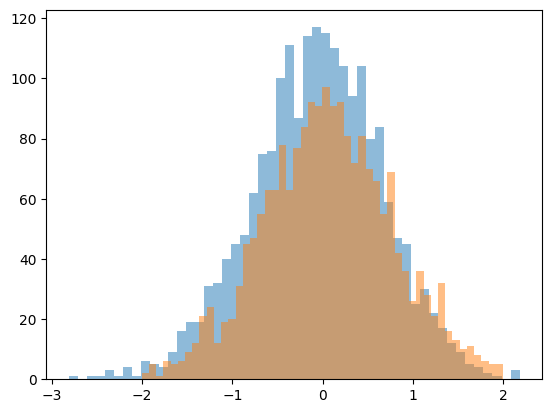

In [30]:
all_prompts = np.array(train_ds["prompt"] * 2)
all_responses = np.array(train_ds["rejected"] + train_ds["preferred"])
all_hiddens = np.stack(results["rej_hiddens"] + results["pref_hiddens"])[:, layer, :]
all_labels = np.concatenate([np.zeros(len(results["rej_hiddens"])), torch.ones(len(results["pref_hiddens"]))])
all_scores = np.concatenate([np.array(results["rej_scores"]), np.array(results["pref_scores"])])
all_LR_probs = LR.predict_proba(all_hiddens)[:, 1]
all_LR_z_scores = (all_LR_probs - all_LR_probs.mean()) / all_LR_probs.std()
all_score_z_scores = (all_scores - all_scores.mean()) / all_scores.std()

diffs = all_LR_z_scores - all_score_z_scores

import matplotlib.pyplot as plt
plt.hist(diffs[all_labels == 0], bins=50, alpha=0.5, label="reject")
plt.hist(diffs[all_labels == 1], bins=50, alpha=0.5, label="prefer")

In [31]:
# get argsort abs(diffs)
sorted_idx = np.argsort(np.abs(diffs))[::-1]

most_disagree = all_responses[sorted_idx[:10]]
disagree_diffs = diffs[sorted_idx[:10]]
for i, row in enumerate(most_disagree):
    print(f"Response {i+1} (diff={disagree_diffs[i]}):")
    if sorted_idx[i] in train_idxs:
        print("TRAIN")
    print(row)
    

Response 1 (diff=-2.810643870848059):
TRAIN
<|assistant|>Hay varios métodos anticonceptivos para mujeres disponibles en el mercado. Aquí están algunos de los más comunes con su eficacia y precio promedio:

Píldoras anticonceptivas: Eficacia del 99%, precio promedio de 20 a 50 dólares por mes.

Parches anticonceptivos: Eficacia del 99%, precio promedio de 30 a 60 dólares por mes.

Anillos anticonceptivos: Eficacia del 99%, precio promedio de 15 a 80 dólares por mes.

Dispositivo intrauterino (DIU): Eficacia del 99%, precio promedio de 500 a 1,000 dólares (se puede durar hasta 10 años).

Esponjas anticonceptivas: Eficacia del 92%, precio promedio de 15 dólares.

Preservativos: Eficacia del 85% a 98%, precio promedio de 1 a 2 dólares cada uno.

Esterilización femenina: Eficacia del 99%, precio promedio de 1,000 a 6,000 dólares.

Depósitos de esperma: Eficacia del 99%, precio promedio de 500 a 1,000 dólares por año.

Es importante destacar que estos precios y eficacias pueden variar depend

# Find *pairs* with most disagreement

In [65]:
# for each row
# if the difference in scores is large and positive (say >1)
# then add rej to LR set with label 0, and pref to LR set with label 1
# then train LR
# then use LR to predict labels for all rows
# and see which rows it disagrees with the RM on most
import numpy as np

prompts = []
responses = []
LR_hiddens = []
labels = []
scores = []
train_idxs = []
rej_much_better_idxs = []
for i, ex in enumerate(train_ds):
    if results["pref_score"][i] - results["rej_score"][i] > 1:  # only train on confident examples
        train_idxs.append(i)
    if results["pref_score"][i] - results["rej_score"][i] < -1:
        rej_much_better_idxs.append(i)

    rej_h = results["rej_hiddens"][i].numpy()
    pref_h = results["pref_hiddens"][i].numpy()
    if random.random() < 0.5:
        LR_hiddens.append(np.concatenate([rej_h, pref_h]))
        labels.append(0)
        scores.append((results["rej_score"][i], results["pref_score"][i]))
        prompts.append(ex["prompt"])
        responses.append((ex["rejected"], ex["preferred"]))
    else:
        LR_hiddens.append(np.concatenate([pref_h, rej_h]))
        labels.append(1)
        scores.append((results["pref_score"][i], results["rej_score"][i]))
        prompts.append(ex["prompt"])
        responses.append((ex["preferred"], ex["rejected"]))

LR_hiddens = np.stack(LR_hiddens)[: , layer, :]
labels = np.array(labels)

layer = 32
LR_train_hiddens = LR_hiddens[train_idxs, :]
LR_train_labels = labels[train_idxs]

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.1, max_iter=10000)
LR.fit(LR_train_hiddens, LR_train_labels)



LogisticRegression(C=0.1, max_iter=10000)

(array([ 1.,  0.,  1.,  1.,  0.,  1.,  1.,  3.,  4.,  9., 11., 16., 17.,
        18., 21., 19., 25., 10., 23., 21., 27., 25., 23., 35., 35., 36.,
        48., 36., 33., 35., 37., 43., 52., 39., 40., 38., 44., 39., 38.,
        32., 19.,  9., 10.,  7., 11.,  3.,  1.,  1.,  0.,  1.]),
 array([-2.96068055, -2.86151941, -2.76235827, -2.66319713, -2.564036  ,
        -2.46487486, -2.36571372, -2.26655258, -2.16739144, -2.0682303 ,
        -1.96906917, -1.86990803, -1.77074689, -1.67158575, -1.57242461,
        -1.47326347, -1.37410234, -1.2749412 , -1.17578006, -1.07661892,
        -0.97745778, -0.87829665, -0.77913551, -0.67997437, -0.58081323,
        -0.48165209, -0.38249095, -0.28332982, -0.18416868, -0.08500754,
         0.0141536 ,  0.11331474,  0.21247588,  0.31163701,  0.41079815,
         0.50995929,  0.60912043,  0.70828157,  0.8074427 ,  0.90660384,
         1.00576498,  1.10492612,  1.20408726,  1.3032484 ,  1.40240953,
         1.50157067,  1.60073181,  1.69989295,  1.79905409,

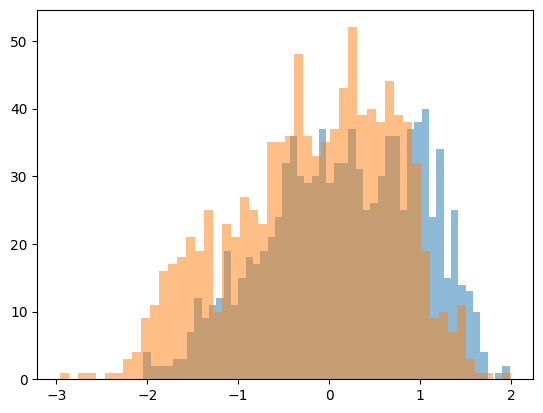

In [66]:
all_LR_probs = LR.predict_proba(LR_hiddens)[:, 1]
all_LR_z_scores = (all_LR_probs - all_LR_probs.mean()) / all_LR_probs.std()
scores = np.array(scores)
all_scores = scores[:, 0] - scores[:, 1]
all_score_z_scores = (all_scores - all_scores.mean()) / all_scores.std()

diffs = all_LR_z_scores - all_score_z_scores

import matplotlib.pyplot as plt
plt.hist(diffs[labels == 0], bins=50, alpha=0.5, label="reject")
plt.hist(diffs[labels == 1], bins=50, alpha=0.5, label="prefer")

In [72]:
# get argsort abs(diffs)
sorted_idx = np.argsort(np.abs(diffs))[::-1]

idxs = sorted_idx[:100]
most_disagree = np.array(responses)[idxs]
disagree_diffs = diffs[idxs]
for idx, pair in zip(idxs, most_disagree):
    if idx not in rej_much_better_idxs:
        continue
    print(prompts[idx])
    print(f"Response {idx} (diff={diffs[idx]}):")
    if diffs[idx] > 0:
        print("  LR prefers first response")
    else:
        print("  LR prefers second response")
    if idx in train_idxs:
        print("TRAIN")
    else:
        print("VAL")

    print(f"RESPONSE 1\n  {pair[0]}")
    print(f"RESPONSE 2\n  {pair[1]}")
    print("\n" * 5)

<|prompter|>i need a python script that outputs rust code to implement bubble sorting for a number array<|endoftext|><|assistant|>Here's a Python script that generates Rust code for bubble sort. Hope this is what you want:
print('fn bubble_sort(nums: &mut [i32]) {')
print('    for i in 0..(nums.len() - 1) {')
print('        for j in 0..(nums.len() - 1 - i) {')
print('            if nums[j] > nums[j + 1] {')
print('                nums.swap(j, j + 1);')
print('            }')
print('        }')
print('    }')
print('}')

And the output Rust code:
fn bubble_sort(nums: &mut [i32]) {
    for i in 0..(nums.len() - 1) {
        for j in 0..(nums.len() - 1 - i) {
            if nums[j] > nums[j + 1] {
                nums.swap(j, j + 1);
            }
        }
    }
}<|endoftext|><|prompter|>What is the algorithmic complexity of this algorithm? Please answer with an analysis using big O notation.<|endoftext|>
Response 109 (diff=-2.044888895313732):
  LR prefers second response
VAL
RESPONSE 1